In [1]:
import pandas as pd
import numpy as n
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.18/04


In [2]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta_65p.csv'
dfByTown = pd.read_csv(urlByTown,na_filter = False)

In [3]:
dfByTown.tail()

,Town,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11
11,Roma,484,506,452,480,482,487,527
12,Bari,57,63,53,56,74,78,54
13,Potenza,7,12,8,12,16,8,18
14,Messina,53,48,65,56,50,49,61
15,Palermo,125,152,126,145,133,149,124


In [30]:
df={}

provinces = n.unique(dfByTown['Town'])
for p in provinces:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

In [31]:
df['Roma'].tail()

,number_of_deaths
Week 7,452
Week 8,480
Week 9,482
Week 10,487
Week 11,527


In [45]:
#Fill Root TGraphErrors
graphs={}
for p in provinces:
    graphs['deceduti_%s'%p]=R.TGraphErrors()
    graphs['deceduti_%s'%p].SetName('deceduti_%s'%p)
                                    
    for i,ni in enumerate(df[p]['number_of_deaths']):
        graphs['deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i])
        graphs['deceduti_%s'%p].SetPointError(i,0,R.TMath.Sqrt(df[p]['number_of_deaths'][i]))
    graphs['deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerStyle(24)
    graphs['deceduti_%s'%p].SetMarkerSize(0.9)
    #Temporary: using as baseline fit of February data                         
    graphs['deceduti_%s'%p].Fit('pol0','RQB+','',5,8.5)

    graphs['eccesso_deceduti_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_%s'%p].SetName('eccesso_deceduti_%s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        graphs['eccesso_deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]-graphs['deceduti_%s'%p].GetFunction('pol0').GetParameter(0))
        graphs['eccesso_deceduti_%s'%p].SetPointError(i,0,R.TMath.Sqrt(df[p]['number_of_deaths'][i]))
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(0.9)
                                                                  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_

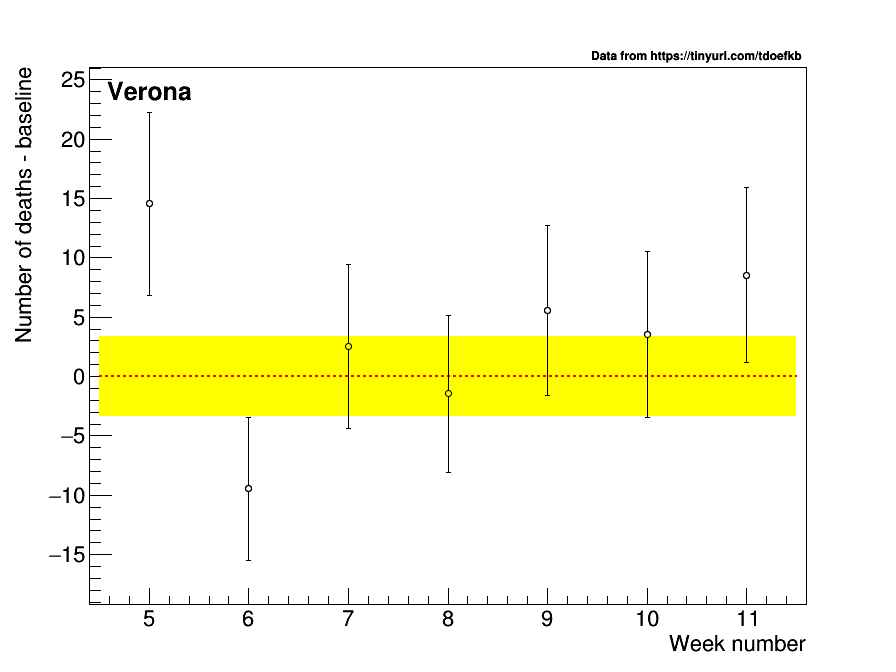

In [63]:
c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

for p in provinces:
    graphs['eccesso_deceduti_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('pol0').GetParError(0)
    box=R.TBox(4.5,-baseline_stdev,11.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(4.5,0,11.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()

    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcess_{:s}".format(p)+ext)



Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_B

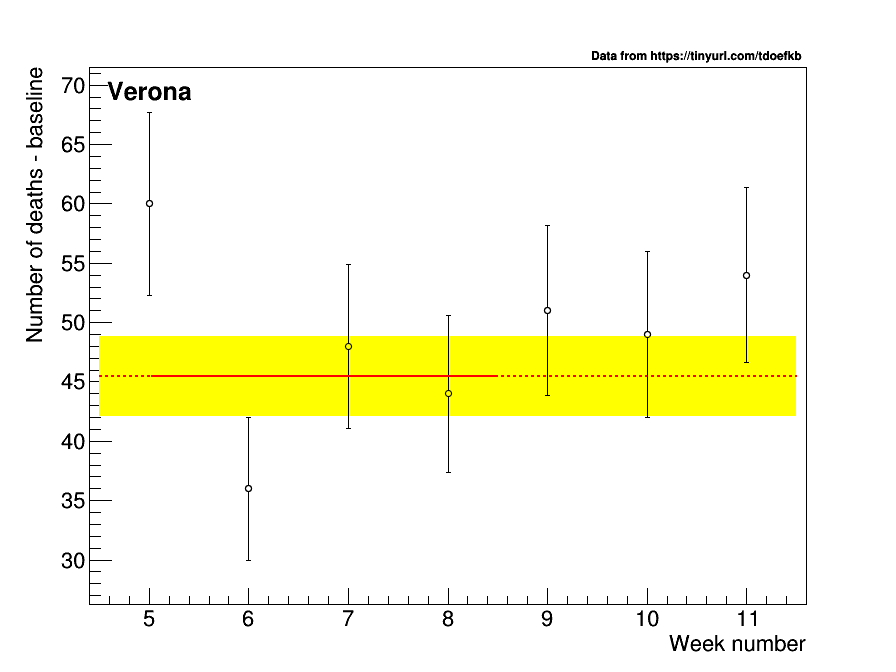

In [64]:
for p in provinces:
    graphs['deceduti_%s'%p].Draw("APSAME")
    graphs['deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline=graphs['deceduti_%s'%p].GetFunction('pol0').GetParameter(0)
    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('pol0').GetParError(0)
    box=R.TBox(4.5,baseline-baseline_stdev,11.5,baseline+baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(4.5,baseline,11.5,baseline)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()

    graphs['deceduti_%s'%p].Draw("PSAME")
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/death_{:s}".format(p)+ext)